# About 

This notebook summarizes the detection results for the TIS anomaly detector that uses an autoencoder to learn the normal behavior of a user on a Windows computer. The neural network is trained on six hours of data and the result files, located in `results/` have the pickle files for training on one hour increments. We only consider the neural network trained on six hours in this notebook. 

In [8]:
import numpy as np 
import matplotlib.pylab as plt
from utils import read_result_file, get_rates, label_window
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

plt.style.use('ggplot')

# Standard Results 

In this section, we load the data from the result file. We are only loading the data that were procuced by the autoencoder that was trained on six hours of data, which is the longest training duration that we have collected.  The reconstruction errors for the attacks are saved in a list that we concatenate together. The detection peformance is measure for by determining the detections for each sample then finding the statistics of interest for classification. These results are the same as the onces that were prepared for the duration of thr TIS project. 

Accuracy: 0.8776793369534153
Precision: 0.9851279000594884
Recall: 0.804273919378339
F-score: 0.8855614973262033
Prevelance: 0.5884538439554158
The threshold is 0.3424218313901582


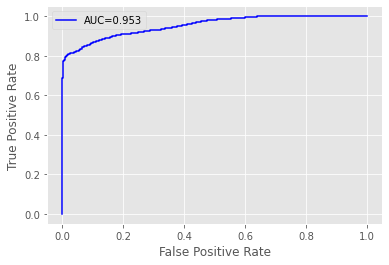

In [9]:
# load the result files
file_path_results = 'results/results_round_6_max_training_hrs8.pkl' 
threshold, errs_attack, errs_normal, errs_train = read_result_file(file_path_results)
# threshold = 0.4

# get the lengths of the normal and attack datasets. note these are going to be different if we use a window 
n_normal = len(errs_normal)
n_attack = np.array([len(errs_attack[i]) for i in range(len(errs_attack))]).sum()

# classify the data with the pre-determined threshold the create the ground truth label vector 
scores_attack = np.concatenate(tuple(errs_attack))
yhat = np.concatenate((1*(errs_normal > threshold), 1*(scores_attack > threshold)))
y = np.concatenate((np.zeros(n_normal), np.ones(n_attack)))
scores = np.concatenate((errs_normal, scores_attack))

# get the detection results and print them out 
_ = get_rates(y, yhat, verbose=True)

print(''.join(['The threshold is ', str(threshold)]))

# plot the ROC
fpr_orig, tpr_orig, thresholds_orig = roc_curve(y, scores)
auc_orig = roc_auc_score(y, scores, average='micro')

plt.figure()
plt.plot(fpr_orig, tpr_orig, c='b', label=''.join(['AUC=', str(round(auc_orig, 3))]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('outputs/roc_original.pdf')

# Window Results 


In this section, we implement a sliding window to form the final classification decision. We consider a sequence of predictions $\hat{y}_1, \hat{y}_2, \ldots, \hat{y}_t$. There is a window size $K$, which is an odd number, and we perform a majority vote over the window to make the final detection decision. Note this method has the potential to cause a lag time in the detection; however, the new feature collector is fast enough that the system will still be faster than the Python data collection tool. 

In [ ]:
window_size = 3
y_hat_attack_window, scores_hat_attack_window = [], []
y_hat_normal_window, scores_hat_normal_window = label_window(1*(errs_normal > threshold), window_size=window_size)
for i in range(len(errs_attack)): 
    pred, score = label_window(1*(errs_attack[i] > threshold), window_size=window_size)
    y_hat_attack_window.append(pred)
    scores_hat_attack_window.append(score) 

# get the lengths of the normal and attack datasets.  
n_normal = len(y_hat_normal_window)
n_attack = np.array([len(y_hat_attack_window[i]) for i in range(len(y_hat_attack_window))]).sum()

# generate the ground truth and detection vectors 
y = np.concatenate((np.zeros(n_normal), np.ones(n_attack)))
yhat = np.concatenate((y_hat_normal_window, np.concatenate(tuple(y_hat_attack_window))))
scores = np.concatenate((scores_hat_normal_window, np.concatenate(tuple(scores_hat_attack_window))))

# get detection results and print them out  
_ = get_rates(y, yhat, verbose=True)

# plot the ROC
fpr_win, tpr_win, thresholds_win = roc_curve(y, scores)
auc_win = roc_auc_score(y, scores, average='micro')

plt.figure()
plt.plot(fpr_win, tpr_win, c='b', label=''.join(['AUC=', str(round(auc_win, 3))]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('outputs/roc_window.pdf')

# Plots 

In [ ]:
plt.figure()

for i in range(len(errs_attack)): 
    plt.hist(errs_attack[i], label=''.join(['Attack ', str(i)]), stacked=True)
plt.hist(errs_normal, label='Normal', stacked=True)
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.legend()
plt.savefig('outputs/density_attack.pdf')


plt.figure()
plt.hist(errs_normal, label='Normal', density=True)
plt.legend()
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.savefig('outputs/density_normal.pdf')


In [ ]:
# generate plots of the sorted reconstruction errors 
plt.figure()
for i in range(len(errs_attack)): 
    plt.plot(np.sort(errs_attack[i]))
plt.xlabel('Sample Number')
plt.ylabel('Reconstruction Error')
plt.savefig('outputs/reconerr_attacks.pdf')

plt.figure()
plt.plot(np.sort(errs_normal), c='b')
plt.xlabel('Sample Number')
plt.ylabel('Reconstruction Error')
plt.savefig('outputs/reconerr_normal.pdf')

In [ ]:
print(''.join(['Normal: ', str(np.mean(errs_normal))]))
for i in range(len(errs_attack)): 
    print(''.join(['Attack ', str(i+1), ': ', str(np.mean(errs_attack[i]))]))

In [ ]:
plt.figure()
plt.plot(fpr_orig, tpr_orig, c='r', label=''.join(['Original AUC=', str(round(auc_orig, 3))]))
plt.plot(fpr_win, tpr_win, c='b', label=''.join(['Window AUC=', str(round(auc_win, 3))]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('outputs/roc_original_window.pdf')